## Урок 6. Домашнее задание
### Градиентный бустинг. AdaBoost.

#### 1. Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

## Реализация алгоритма градиентного бустинга

Реализуем средствами Python алгоритм градиентного бустинга для деревьев решений.

Реализация деревьев решений была дважды продемонстрирована в предыдущих уроках, в этом не будем ее повторять и возьмем готовую реализацию дерева решений для регрессии из библиотеки `sklearn`.

In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

Используем один из "игрушечных" датасетов из той же библиотеки.

In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге
$$a_{N}(x) = \sum^{N}_{n=1}\gamma_{n}b_{n}(x).$$

In [5]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [6]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [7]:
def bias(y, z):
    return (y - z)

Реализуем функцию обучения градиентного бустинга.

In [8]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        # базовый алгоритм
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [9]:
# Число деревьев в ансамбле
n_trees = [10, 30, 50, 70, 90, 140, 200]

# для простоты примем коэффициенты равными 1
# coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = [1, 3, 5, 7, 9]

# Шаг
eta = 0.05

In [10]:
# изменяем функцию на возврат  ошибки
def evaluate_alg_ret(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    train_err = mean_squared_error(y_train, train_prediction)

    test_prediction = gb_predict(X_test, trees, coefs, eta)
    test_err = mean_squared_error(y_test, test_prediction)
    
    return train_err, test_err

In [11]:
# находим изменение ошибки на обучающей и тестовой выборках от числа деревьев
max_depth_c = max_depth[1] # задаем глубину деревьев
train_error_on_n_trees = []
test_error_on_n_trees = []
for trees in n_trees:
    # для простоты примем коэффициенты равными 1
    coefs = [1] * trees
    trees, train_errors, test_errors = gb_fit(trees, max_depth_c, X_train, X_test, y_train, y_test, coefs, eta)
    train_err, test_err = evaluate_alg_ret(X_train, X_test, y_train, y_test, trees, coefs, eta)
    train_error_on_n_trees.append(train_err)
    test_error_on_n_trees.append(test_err)

In [12]:
# изменение ошибки на обучающей выборке от числа деревьев
train_error_on_n_trees

[12072.787623681397,
 3334.86019630729,
 1908.3165419833647,
 1495.8007893219938,
 1308.5478784067009,
 999.7741307971776,
 772.8445001107523]

In [13]:
# изменение ошибки на тестовой выборке от числа деревьев
test_error_on_n_trees

[12884.04847372681,
 5033.867263637544,
 3968.483603155926,
 3753.943038290223,
 3727.4023692891515,
 3813.4363871888972,
 3885.4214808833476]

In [14]:
# находим изменение ошибки на обучающей и тестовой выборках от глубины деревьев
n_trees_c = n_trees[2] # задаем число деревьев
train_error_on_max_depth = []
test_error_on_max_depth = []
for depth in max_depth:
    # для простоты примем коэффициенты равными 1
    coefs = [1] * n_trees_c
    trees, train_errors, test_errors = gb_fit(n_trees_c, depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_err, test_err = evaluate_alg_ret(X_train, X_test, y_train, y_test, trees, coefs, eta)
    train_error_on_max_depth.append(train_err)
    test_error_on_max_depth.append(test_err)

In [15]:
# изменение ошибки на обучающей выборке от глубины деревьев
train_error_on_max_depth

[3091.665530229786,
 1908.3165419833647,
 844.7408347275044,
 349.16892815990343,
 210.30638150613126]

In [16]:
# изменение ошибки на тестовой выборке от глубины деревьев
test_error_on_max_depth

[3940.3214458167417,
 3968.483603155926,
 4402.906937549065,
 4676.25913440068,
 5312.863146132186]

Построим графики зависимости ошибки на обучающей и тестовой выборках

In [17]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [18]:
def get_error_plot(iterator, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    # plt.xlim(min(iterator), max(iterator))
    plt.plot(iterator, train_err, label='train error')
    plt.plot(iterator, test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

График зависимости ошибки на обучающей и тестовой выборках от числа деревьев

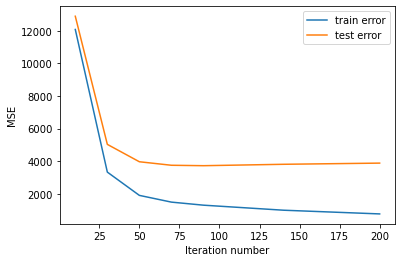

In [19]:
get_error_plot(n_trees, train_error_on_n_trees, test_error_on_n_trees)

График зависимости ошибки на обучающей и тестовой выборках от глубины деревьев

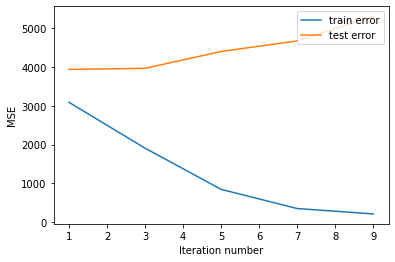

In [20]:
get_error_plot(max_depth, train_error_on_max_depth, test_error_on_max_depth)

При увеличении числа деревьев ошибка уменьшается, но при значительно большом числе деревьев ошибка на тестовой выборке начинает расти. Наблюдается незначительное переобучение.

Увеличение глубины деревьев приводит к увеличению ошибки на тестовой выборке, а на обучающей же ошибка уменьшается. Это свидетельствует о переобучении.

Увеличение глубины для данной выборки быстрее приводит в переобучению, чем увеличение числа деревьев.

#### 2*. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.